In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

In [21]:
df_train = pd.read_csv("../data/internal/ml/train_7d.csv")
df_test = pd.read_csv("../data/internal/ml/test_7d.csv")
df_sp500 = pd.read_csv("../data/external/s&p500_returns_adrianmross.csv")

In [22]:
df_sp500["date"] = pd.to_datetime(df_sp500["date"])

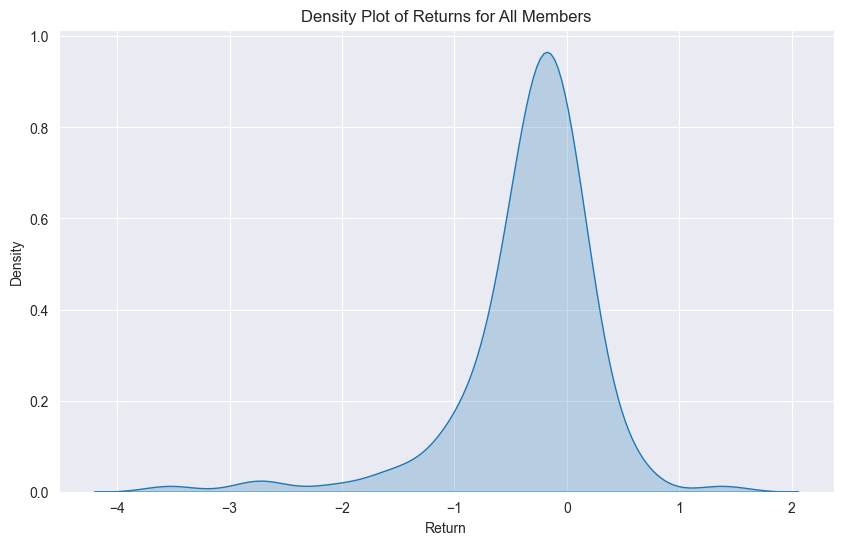

In [23]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_train, x="normalized_return", fill=True)
plt.title("Density Plot of Returns for All Members")
plt.xlabel("Return")
plt.ylabel("Density")
plt.show()

In [24]:
def calc_threshold(df):
    returns = df["normalized_return"].to_list()
    median_return = np.median(returns)
    std_return = np.std(returns)
    threshold = median_return + (std_return * 0.25)
    return threshold


threshold_train = calc_threshold(df_train)
threshold_test = calc_threshold(df_test)

2 categories:
1. anomalous: return > mean_return + std_return
2. normal: return <= mean_return + std_return

In [25]:
df_train["category"] = df_train["normalized_return"].apply(
    lambda x: 1 if x > threshold_train else 0
)
print(len(df_train[df_train["category"] == 1]), len(df_train[df_train["category"] == 0]))

df_test["category"] = df_test["normalized_return"].apply(lambda x: 1 if x > threshold_test else 0)
print(len(df_test[df_test["category"] == 1]), len(df_test[df_test["category"] == 0]))

45 94
0 59


In [26]:
X_train = df_train.drop(
    [
        "name",
        "avg_return",
        "return_volatility",
        "cumulative_return",
        "start_date",
        "end_date",
        "sp500_cumulative_return",
        "normalized_return",
        "category",
    ],
    axis=1,
)
y_train = df_train["category"]

X_test = df_test.drop(
    [
        "name",
        "avg_return",
        "return_volatility",
        "cumulative_return",
        "start_date",
        "end_date",
        "sp500_cumulative_return",
        "normalized_return",
        "category",
    ],
    axis=1,
)
y_test = df_test["category"]

## Random Forest Classifier

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END classifier__max_depth=None, classifier__max_features=log2, classifier__min_samples_leaf=4, classifier__min_samples_split=5, classifier__n_estimators=200; total time=   0.2s
[CV] END classifier__max_depth=None, classifier__max_features=log2, classifier__min_samples_leaf=4, classifier__min_samples_split=5, classifier__n_estimators=500; total time=   0.4s
[CV] END classifier__max_depth=10, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=100; total time=   0.1s
[CV] END classifier__max_depth=10, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=100; total time=   0.1s
[CV] END classifier__max_depth=10, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=100; total time=   0.1s
[CV] END classifier__max_depth=1

/Users/liamtessendorf/Programming/Uni/2_Master/3_HS24_Programming/us-congress-members-trading-analysis/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
254 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/liamtessendorf/Programming/Uni/2_Master/3_HS24_Programming/us-congress-members-trading-analysis/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/liamtessendorf/Programming/Uni/2_Master/3_HS24_Programming/us-congress-members-trading-analysis/venv/lib/

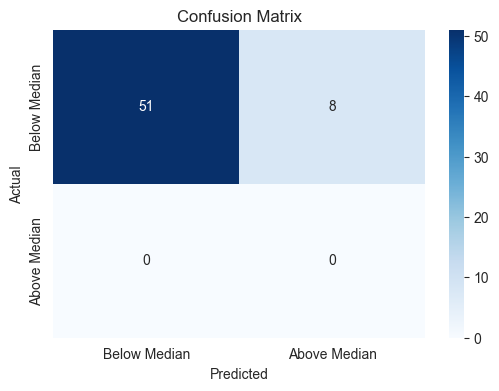

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

rf_classifier = RandomForestClassifier(random_state=42)

pipeline = Pipeline([("classifier", rf_classifier)])

param_grid = {
    "classifier__n_estimators": [100, 200, 500],
    "classifier__max_depth": [None, 10, 20, 30],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4],
    "classifier__max_features": ["auto", "sqrt", "log2"],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=pipeline, param_grid=param_grid, cv=cv, scoring="accuracy", n_jobs=-1, verbose=2
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("Best Hyperparameters:\n", grid_search.best_params_)

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Test Set:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Below Median", "Above Median"],
    yticklabels=["Below Median", "Above Median"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Accuracy on Test Set: 0.3390

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.34      0.51        59
           1       0.00      0.00      0.00         0

    accuracy                           0.34        59
   macro avg       0.50      0.17      0.25        59
weighted avg       1.00      0.34      0.51        59



/Users/liamtessendorf/Programming/Uni/2_Master/3_HS24_Programming/us-congress-members-trading-analysis/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liamtessendorf/Programming/Uni/2_Master/3_HS24_Programming/us-congress-members-trading-analysis/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liamtessendorf/Programming/Uni/2_Master/3_HS24_Programming/us-congress-members-trading-analysis/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

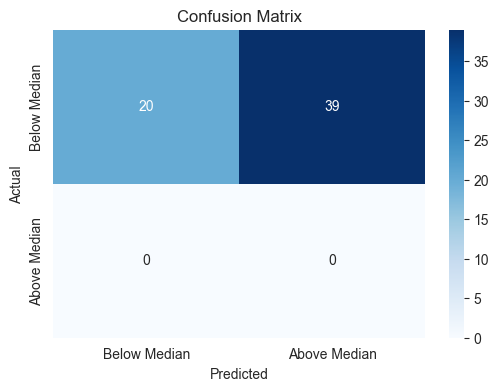

In [28]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logistic_regressor = LogisticRegression(max_iter=1000, random_state=42)
logistic_regressor.fit(X_train_scaled, y_train)

y_pred = logistic_regressor.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Set: {accuracy:.4f}")

print("\nClassification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Below Median", "Above Median"],
    yticklabels=["Below Median", "Above Median"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()